In [1]:
#imports
#Main Library (Actual Neural Network Part)
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import neural_structured_learning as nsl

# #Helper Libraries (in order to interpret and view the data)
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Prints if a GPU is detected by the TensorFlow system
print(len(tf.config.list_physical_devices('GPU')) > 0)

True


In [3]:
#importing the MNIST dataset from tensorflow
from tensorflow.keras.datasets import mnist 
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

[3]
[2]
[1]
[18]
[4]
[8]
[11]
[0]
[61]
[7]


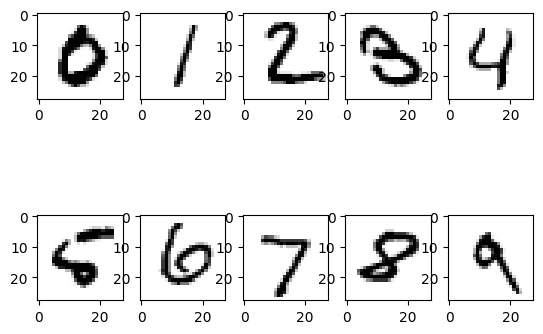

In [4]:
#validating the data (making sure this is the data I want)
fig, ax = plt.subplots(2,5)
ax = ax.flatten()
for i in range(10):
    im_idx = np.argwhere(Y_test == i)[0]
    print(im_idx)
    plottable_image = np.reshape(X_test[im_idx], (28, 28))
    ax[i].imshow(plottable_image, cmap='gray_r')

In [5]:
#checking the format of the data because I want the data to be scaled from 0 to 1
print(X_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

In [6]:
#scaling the data from 0 to 1 as float (decimal) numbers
X_train, X_test = X_train / 255.0, X_test / 255.0

In [7]:
#creating the model - Sequential 
model = models.Sequential()
#first conv. layer and pooling layer
model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
#second conv. layer and pooling layer
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#last conv. layer
model.add(layers.Conv2D(32, (3, 3), activation='relu'))

In [8]:
#checking the output shape of the last conv. layer, so I can set the last Dense layer correctly 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 4)         40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        592       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
Total params: 5,272
Trainable params: 5,272
Non-trainabl

In [9]:
#Flattening layer will create vectors in order for the neural netowrk to actually make predictions
model.add(layers.Flatten())
#adding the last dense layer to allow the neural network to classify the images
model.add(layers.Dense(32, activation = 'relu'))
#classification layer
model.add(layers.Dense(10, activation = "softmax"))

In [10]:
#confirming that my model is correct
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 4)         40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        592       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 flatten (Flatten)           (None, 288)               0

In [11]:
#loading the model
base_model = tf.keras.models.load_model('complete_saved_mnist_model')

In [12]:
#checking if the model is valid and loaded
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 4)         40        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 4)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 16)        592       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 flatten_2 (Flatten)         (None, 288)              

In [13]:
adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.05)
adv_model = nsl.keras.AdversarialRegularization(model, adv_config = adv_config)

In [14]:
#compiler which configures the model
adv_model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

In [15]:
#training the model
history = adv_model.fit({'feature': X_train, 'label': Y_train}, batch_size = 10, epochs = 20, verbose = 1,
                    shuffle = True)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6000/6000 [==============================] - 106s 14ms/step - loss: 0.2189 - sparse_categorical_crossentropy: 0.1794 - sparse_categorical_accuracy: 0.9438 - scaled_adversarial_loss: 0.0395
Epoch 2/20
6000/6000 [==============================] - 91s 15ms/step - loss: 0.0788 - sparse_categorical_crossentropy: 0.0636 - sparse_categorical_accuracy: 0.9801 - scaled_adversarial_loss: 0.0152
Epoch 3/20
6000/6000 [==============================] - 88s 15ms/step - loss: 0.0578 - sparse_categorical_crossentropy: 0.0464 - sparse_categorical_accuracy: 0.9850 - scaled_adversarial_loss: 0.0114
Epoch 4/20
6000/6000 [====================

In [16]:
#verifying that the this is a completely untrained neural network
adv_model.evaluate({'feature': X_test, 'label': Y_test})

313/313 [==============================] - 5s 15ms/step - loss: 0.0736 - sparse_categorical_crossentropy: 0.0580 - sparse_categorical_accuracy: 0.9877 - scaled_adversarial_loss: 0.0157


[0.07364562153816223,
 0.057960350066423416,
 0.9876999855041504,
 0.01568523980677128]

In [26]:
model.evaluate(X_test, Y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.0581 - accuracy: 0.9877


[0.05805298313498497, 0.9876999855041504]

In [31]:
#Creating the adversarial attack for adversarial training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def create_adv(input_image, input_label, model_type = "adv_model"):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    if(model_type == "model"):
      prediction = base_model(input_image)
    else:
      prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  gradient = tape.gradient(loss, input_image)
  signed_grad = tf.sign(gradient)
  return signed_grad

def fgsm(input_image, input_label, eps=0.25, model_type = "adv_model"):
  perturbation = create_adv(input_image, input_label, model_type)
  adv_image = input_image + perturbation * eps
  adv_image = tf.clip_by_value(adv_image, 0, 1)

  return adv_image

def pgd(input_image, input_label, num_steps=100, eps=0.25, alpha=0.01, model_type = "adv_model"):
  adv_image = input_image
  for i in range(num_steps):
    adv_image = fgsm(adv_image, input_label, alpha, model_type)
    perturbation = adv_image - input_image
    perturbation = tf.clip_by_value(perturbation, -eps, eps)
    adv_image = input_image + perturbation
  
  return adv_image


In [1]:
adv_x = fgsm(tf.convert_to_tensor(X_test), Y_test)
adv_model.evaluate({'feature': adv_x, 'label': Y_test})

NameError: name 'fgsm' is not defined

In [38]:
model.evaluate(x = adv_x, y =  Y_test)

313/313 [==============================] - 3s 9ms/step - loss: 33.1288 - accuracy: 0.0070


[33.12879943847656, 0.007000000216066837]

In [37]:
#saving the model so I don't have to keep training the network
adv_model.save('complete_saved_adv_mnist_model')

INFO:tensorflow:Assets written to: complete_saved_adv_mnist_model\assets


INFO:tensorflow:Assets written to: complete_saved_adv_mnist_model\assets


3


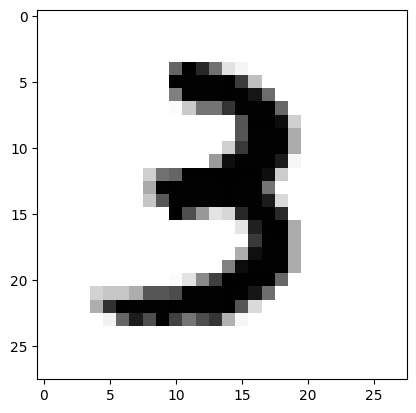

In [35]:
#shows the benign image
#allows me to test specific images
testing_index = 4983
print(Y_test[testing_index])
plottable_image = np.reshape(X_test[testing_index], (28, 28))
plt.imshow(plottable_image, cmap='gray_r')

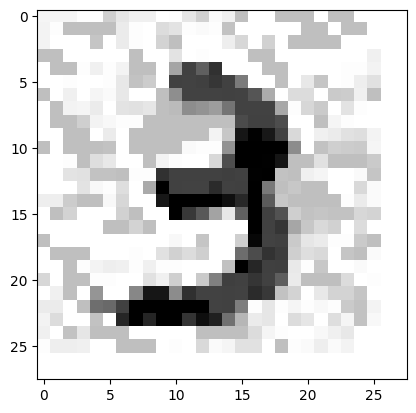

In [36]:
#shows the malignant (pgd) image
plt.figure()
plt.imshow(adv_x[testing_index]*0.5+0.5, cmap = "gray_r")

In [ ]:
base_model.predict(np.expand_dims(adv_x[testing_index], axis = 0))

array([[5.8694376e-11, 8.7084807e-08, 5.2313806e-07, 9.3052899e-03,
        8.2476392e-05, 3.5935179e-03, 3.5809316e-09, 1.7957740e-04,
        1.7894299e-03, 9.8504907e-01]], dtype=float32)

In [ ]:
model.set_weights(adv_model.get_weights())

In [ ]:
model.predict(np.expand_dims(adv_x[testing_index], axis = 0))


array([[1.84473986e-12, 1.04121423e-08, 1.03669656e-07, 9.99887109e-01,
        4.36470874e-13, 2.04247872e-08, 4.22120834e-13, 6.11936835e-10,
        1.12810390e-04, 1.38713019e-09]], dtype=float32)